In [1]:
import mozo2 

import importlib
importlib.reload(mozo2)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mozo import compare_and_combine_2, Diff, merge_with_features, num_to_range_categories
import pandas as pd
import numpy as np
np.random.seed(0)

import xgboost as xgb

from scipy import stats
import math 
import datetime 

from sklearn.metrics import r2_score, mean_absolute_error
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
from sklearn.svm import SVC

from sklearn.metrics import r2_score, f1_score, mean_absolute_error, mean_squared_error

from scikitplot.estimators import plot_learning_curve

import time
from datetime import datetime


print_plots_by_type(total, type =[np.object])

In [3]:
## modelowanie

In [2]:
# import warnings
# warnings.filterwarnings("ignore")

total = pd.read_csv('~/pml7/konkurs/output/newest_total_20201101_07_20.h5.csv')
total.info(verbose=True)

train_30 = pd.read_hdf('output/train_30.h5', 'data') 
test_car_ids = train_30['car_id'].values

train_70 = total[~total['car_id'].isin(test_car_ids) & ~total['price_value'].isna()]
train_30 = total[total['car_id'].isin(test_car_ids)]

print(len(total.index))
print(len(total[~total['price_value'].isna()].index))

print(train_70['price_value'].isna().sum())
print(train_30['price_value'].isna().sum())

train_100 = total[~total['price_value'].isna()]
print(train_100['price_value'].isna().sum())

global_min = total[~total['price_value'].isna()].price_value.min()

test = total[total['price_value'].isna()]
train = total[~total['price_value'].isna()]


/home/conda/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (3,86,161) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 218 columns):
 #   Column                                                  Dtype  
---  ------                                                  -----  
 0   breadcrumb                                              object 
 1   created_at                                              object 
 2   price_currency                                          object 
 3   price_details                                           object 
 4   price_value                                             float64
 5   seller_address                                          object 
 6   seller_name                                             object 
 7   seller_type                                             object 
 8   feature_czujniki_parkowania_przednie                    bool   
 9   feature_poduszka_powietrzna_chroniąca_kolana            bool   
 10  feature_kurtyny_powietrzne                             

160616
106494
0
0
0


In [10]:
start_vars = np.sort([
# 2776.816641956884
#     'created_at_unix', 'encoded_param_rodzaj_paliwa_2', 'encoded_param_skrzynia_biegów_2', 'encoded_param_typ_2', 'feature_asr__kontrola_trakcji_', 'feature_cd', 'feature_centralny_zamek', 'feature_czujnik_martwego_pola', 'feature_elektrycznie_ustawiane_fotele', 'feature_elektrycznie_ustawiane_lusterka', 'feature_isofix', 'feature_klimatyzacja_automatyczna', 'feature_klimatyzacja_manualna', 'feature_ogrzewanie_postojowe', 'feature_podgrzewane_tylne_siedzenia', 'feature_relingi_dachowe', 'feature_tapicerka_skórzana', 'feature_światła_led', 'feature_światła_przeciwmgielne', 'longitude', 'longitude_na_mean', 'model_8790', 'model_XGBRegressor_3293_22097_', 'new_param_kolor_cat', 'new_param_liczba_pozostałych_rat_cat', 'new_param_marka_pojazdu_cat', 'new_param_oferta_od_cat', 'new_param_opłata_początkowa_cat', 'new_seller_name_cat', 'new_vin_flex_fuel_cat', 'new_vin_model_cat', 'new_vin_portrait_cat', 'new_vin_security_cat', 'ogloszenie_rok', 'param_akryl__niemetalizowany_', 'param_bezwypadkowy', 'param_faktura_vat', 'param_homologacja_ciężarowa', 'param_ile_lat_temu_produkcja', 'param_liczba_miejsc_2', 'param_liczba_pozostałych_rat_2', 'param_matowy', 'param_moc', 'param_perłowy', 'param_pierwsza_rejestracja_10_lat', 'param_pojemność_skokowa', 'param_przebieg', 'param_rok_produkcji', 'param_tuning', 'param_uszkodzony', 'param_vin_len'
])

# 'model_8790' = car_price_log_Vladimir_categories_xgb.csv; 5637.56722; "opis": "Vladimir z kategorialnymi mae na train_30"

black_list = ['car_id', 'price_details', 'price_value', 'price_value_log', 'price_value_pln', 'price_value_pln_log_transl', 'new_cat_price_value',
#               *[x for x in total.columns if x.startswith('model_')],
              'model_XGBRegressor_2195_24982_po_hiperopcie_caly_train', #train_100, przeuczony
              'model_XGBRegressor_3293_22097_', #train_100
              'longitude_na_mean', 'latitude_na_mean', #gorsze w xbfir
              *total.columns[total.isnull().any()],
             ]

feats3 = total.select_dtypes(include=[np.number, np.bool]).columns
feats3 = [x for x in feats3 if x not in black_list]
feats3 = np.sort(feats3)

print(total[start_vars].info(verbose=True))

print(total[feats3].info(verbose=True))
print(total[feats3].columns[total[feats3].isnull().any()])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 51 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   created_at_unix                          160616 non-null  float64
 1   encoded_param_rodzaj_paliwa_2            160616 non-null  int64  
 2   encoded_param_typ_2                      160616 non-null  int64  
 3   feature_abs                              160616 non-null  bool   
 4   feature_asr__kontrola_trakcji_           160616 non-null  bool   
 5   feature_bluetooth                        160616 non-null  bool   
 6   feature_cd                               160616 non-null  bool   
 7   feature_czujniki_parkowania_przednie     160616 non-null  bool   
 8   feature_elektrycznie_ustawiane_fotele    160616 non-null  bool   
 9   feature_elektrycznie_ustawiane_lusterka  160616 non-null  bool   
 10  feature_gniazdo_sd              

Index([], dtype='object')


In [12]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from catboost import CatBoostRegressor
from functools import partial

def objective(space):
    
    params = {
        'iterations': int(space['iterations']),
        'depth': int(space['depth']),
        'learning_rate': np.log(space['learning_rate']),
        'random_strength': np.log(space['random_strength']),
        'bagging_temperature': space['bagging_temperature'],
        'border_count': int(space['border_count']),
        'l2_leaf_reg': int(space['l2_leaf_reg']),
        
        'random_state': 6950,
        'silent' : True,
    }
    
    mae, r2, model, model_cl, learning_curve_plot = mozo2.train_and_submit(train_70, train_30, total.loc[total['price_value'].isna(),], 
                 start_vars, global_min, 
                 CatBoostRegressor, params, digitize=None, subfolder='Hiperopt',
                 file_sufix = 'from_hiperopt', opis='', 
                 learning_curve = False, 
                 add_model_column_min = -1, total = total, 
                 save_min=2776, kaggle_min=-1)
    
    return{'loss':mae, 'status': STATUS_OK }
    
space ={
     'iterations': hp.quniform('iterations',10, 300, 1),
     'depth': hp.quniform('depth',1, 16, 1),
     'learning_rate': hp.loguniform('learning_rate', 0.001, 1.0),
     'random_strength': hp.loguniform('random_strength',1e-9, 10),
     'bagging_temperature': hp.uniform('bagging_temperature',0.0, 1.0),
     'border_count': hp.quniform('border_count',1, 255, 1),
     'l2_leaf_reg': hp.quniform('l2_leaf_reg', 2, 30, 1),
}


In [9]:
import warnings
warnings.filterwarnings("ignore")

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=200,
            trials=trials)

try:
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['n_estimators'] = int(best_params['n_estimators'])
    best_params['random_state'] = int(best_params['random_state'])
    best_params['min_child_weight'] = int(best_params['min_child_weight'])
except:
    print('')
    
print("The best params: ", best_params)
time_hyper_tuning_end = datetime.now().strftime("%H:%M:%S")


mea: 3335.232415957258                                 
r2: 0.9671579584772145                                 
mea: 3542.2639761587284                                                           
r2: 0.9621880227567479                                                            
mea: 2909.614079279839                                                            
r2: 0.9795198904575466                                                            
mea: 3837.2246667694344                                                           
r2: 0.9538537575997912                                                            
mea: 3097.649581305323                                                            
r2: 0.9767448751015828                                                            
mea: 3543.253643538788                                                            
r2: 0.9691749422662648                                                            
mea: 6777.016761510776                                    

r2: 0.9568589535257086                                                            
mea: 2933.897200653317                                                              
r2: 0.9777544335139615                                                              
mea: 3102.2729476258514                                                             
r2: 0.9765643112116487                                                              
mea: 3078.0202136182706                                                             
r2: 0.9762819594797902                                                              
mea: 8344.007984842845                                                              
r2: 0.7722304629465846                                                              
mea: 2883.0846683852374                                                             
r2: 0.9806018317630208                                                              
mea: 3583.7469011071244                                            

r2: 0.9744307696657925                                                           
mea: 2985.7553287827086                                                          
r2: 0.9781333195567347                                                           
mea: 3064.297217865115                                                           
r2: 0.9752136691540387                                                           
mea: 3371.6869089988627                                                           
r2: 0.9717584186548125                                                            
mea: 3146.1519967965974                                                           
r2: 0.9717297279078512                                                            
mea: 3111.1671783217444                                                           
r2: 0.9746559643265044                                                            
mea: 2870.458877529484                                                            
r2: 0.977

mea: 2827.8993692664935                                                             
r2: 0.9798698447463439                                                              
mea: 3160.150977959841                                                              
r2: 0.9771695334647192                                                              
mea: 3079.640823831813                                                              
r2: 0.9773214653129142                                                              
mea: 2880.277074236152                                                              
r2: 0.9801338832097887                                                              
mea: 2875.1948201324717                                                             
r2: 0.9781937738888056                                                              
mea: 2807.5139293352645                                                             
r2: 0.9803059385461314                                           

mea: 3173.1180266195106                                                             
r2: 0.9781384483529825                                                              
mea: 3012.5561382452256                                                             
r2: 0.9767032381021805                                                              
mea: 2970.9781005971045                                                             
r2: 0.9793093987206298                                                              
mea: 2895.163025454939                                                              
r2: 0.9786900498687569                                                              
mea: 3020.001438612064                                                              
r2: 0.979408033009908                                                               
mea: 4221.086035330335                                                              
r2: 0.9486778529683242                                           

100%|██████████| 200/200 [59:01<00:00, 17.71s/trial, best loss: 2507.0378151722584]

The best params:  {'colsample_bytree': 0.9181187900296514, 'learning_rate': 0.0903414186411988, 'max_depth': 67, 'min_child_weight': 15.0, 'random_state': 2800.0, 'reg_alpha': 2.0196611154090625, 'reg_lambda': 0.5903543283480963, 'subsample': 0.6459932503256092}


100%|██████████| 100/100 [16:53<00:00, 10.14s/trial, best loss: 2787.278884227062]

{'colsample_bytree': 0.9134536831915041, 
 'learning_rate': 0.5883941782527925, 
 'max_depth': 7, 
 min_child_weight': 83.0, 
 'random_state': 1900.0, 
 'reg_alpha': 1.7994655573932083, 
 'reg_lambda': 0.6151432003199035, 
 'subsample': 0.958397313380928}

100%|██████████| 200/200 [13:12<00:00,  3.96s/trial, best loss: 2554.0055140805002]

The best params:  {'colsample_bytree': 0.9977314361800289, 
                   'learning_rate': 0.12918308385376528, 
                   'max_depth': 29, 
                   'min_child_weight': 50.0, 
                   'random_state': 950.0, 
                   'reg_alpha': 1.732596305325749, 
                   'reg_lambda': 0.3572913121907399, 
                   'subsample': 0.999649854200746}


mea: 2608.375895255625
r2: 0.9787476450407201
Learning curve for: XGBRegressor


/home/conda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


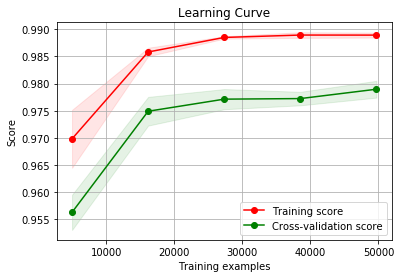

In [37]:
# params = {    
#     'n_jobs': 12, 

#     'n_estimators': 50, 
#     'learning_rate': 0.3, 
#     'subsample': 0.5, 
#     'colsample_bytree': 0.9,
#     'max_depth': 10, 
# }

params = {'colsample_bytree': 0.9977314361800289, 
                   'learning_rate': 0.12918308385376528, 
                   'max_depth': 29, 
                   'min_child_weight': 50, 
                   'random_state': 950, 
                   'reg_alpha': 1.732596305325749, 
                   'reg_lambda': 0.3572913121907399, 
                   'subsample': 0.999649854200746}

mae, r2, model, model_cl, learning_curve_plot = train_and_submit(train_70, train_30, total.loc[total['price_value'].isna(),], 
             start_vars, global_min, 
             xgb.XGBRegressor, params, digitize=None, subfolder='',
             file_sufix = 'po_hiperopcie', opis='', 
             learning_curve = True, 
             add_model_column_min = 3000, total = total, 
             save_min=3000, kaggle_min=-1)


mea: 2195.2498155859885
r2: 0.9840022215542306
Learning curve for: XGBRegressor


/home/conda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(2195.2498155859885,
 0.9840022215542306,
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9977314361800289, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.12918308385376528, max_delta_step=0, max_depth=29,
              min_child_weight=50, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=950,
              reg_alpha=1.732596305325749, reg_lambda=0.3572913121907399,
              scale_pos_weight=1, subsample=0.999649854200746,
              tree_method='exact', validate_parameters=1, verbosity=None),
 'model_XGBRegressor_2195_24982_po_hiperopcie_caly_train',
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd3ef62eb50>)

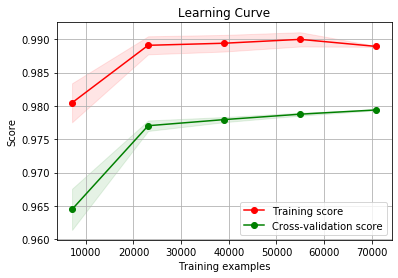

In [64]:
train_and_submit(train, train_30, total.loc[total['price_value'].isna(),], 
             start_vars, global_min, 
             xgb.XGBRegressor, params, digitize=None, subfolder='',
             file_sufix = 'po_hiperopcie_caly_train', opis='', 
             learning_curve = True, 
             add_model_column_min = 3000, total = total, 
             save_min=3000, kaggle_min=-1)

# del total['model_XGBRegressor_2608_37590_po hiperopcie']
del total['model_XGBRegressor_2195_24982_po hiperopcie']

print(total.info(verbose=True))


In [69]:
save_dataframe_total()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160616 entries, 0 to 160615
Data columns (total 218 columns):
 #   Column                                                  Dtype  
---  ------                                                  -----  
 0   breadcrumb                                              object 
 1   created_at                                              object 
 2   price_currency                                          object 
 3   price_details                                           object 
 4   price_value                                             float64
 5   seller_address                                          object 
 6   seller_name                                             object 
 7   seller_type                                             object 
 8   feature_czujniki_parkowania_przednie                    bool   
 9   feature_poduszka_powietrzna_chroniąca_kolana            bool   
 10  feature_kurtyny_powietrzne                             

In [5]:
mozo2.get_kaggle_board()

          teamName                submissionDate       score
0       adamskorek        2020-11-01T09:08:37.5Z  5137.81705
1           pelele  2020-10-31T19:46:31.2633333Z  5369.00636
2             mozo  2020-10-30T16:38:46.7333333Z  5466.72056
3  Adrian Mich***i       2020-10-31T12:30:08.39Z  5578.96222
4   Remek Półtorak  2020-10-31T19:09:20.1866667Z  5581.85197


In [38]:
# model = RandomForestRegressor(n_estimators=50, max_depth=7).fit(X_sub_train, y_sub_train) 
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.svm import SVC


# perm = PermutationImportance(model).fit(X_sub_test, y_sub_test) 
eli5.show_weights(perm, feature_names=random_feats, top=50) 


/home/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/conda/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


NameError: name 'perm' is not defined